# Proyek Klasifikasi Gambar: Fruits Classification 🍇
- **Nama:** Dila Aura Futri
- **Email:** mrkhyuck.dila@gmail.com
- **ID Dicoding:** [Input Username]

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install pipreqs

In [2]:
!pip install tensorflowjs

  Using cached tensorflowjs-4.22.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached packaging-23.2-py3-none-any.whl.metadata (3.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [3]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from google.colab import files


# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise


# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [5]:
from google.colab import userdata
import os

# Ambil kredensial dari Google Colab Secrets
kaggle_username = userdata.get('popo')  # Nama pengguna
kaggle_key = userdata.get('siroyo')     # Kunci API

# Set variabel lingkungan untuk Kaggle
os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_key


In [6]:
!rm -rf fruits-classification/

In [7]:
!kaggle datasets download -d utkarshsaxenadn/fruits-classification

Dataset URL: https://www.kaggle.com/datasets/utkarshsaxenadn/fruits-classification
License(s): CC0-1.0


In [8]:
# Ekstrak dataset
!unzip fruits-classification.zip -d fruits-classification


#https://www.kaggle.com/datasets/utkarshsaxenadn/fruits-classification/code

Streaming output truncated to the last 5000 lines.
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1950).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1952).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1953).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1955).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1956).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1957).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1958).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1959).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (196).jpeg  
  inflating: fruits-classification/Fruits Classification/train/Grape/Grape (1960).jpeg  
  inflating: fruits-classification/Fruits Classification/tra

### Data Preprocessing

In [9]:
import os
import shutil
# Cek apakah folder utama ada
print("Cek folder utama:", os.path.exists("fruits-classification"))

# Cek apakah subfolder train ada
print("Cek folder train:", os.path.exists("fruits-classification/train"))

# Cek apakah subfolder test ada
print("Cek folder test:", os.path.exists("fruits-classification/test"))

# Cek apakah subfolder valid ada
print("Cek folder valid:", os.path.exists("fruits-classification/valid"))


Cek folder utama: True
Cek folder train: False
Cek folder test: False
Cek folder valid: False


In [10]:
import os
import shutil

# Direktori asal untuk train, test, dan validation
train_dir = "fruits-classification/Fruits Classification/train"
test_dir = "fruits-classification/Fruits Classification/test"
valid_dir = "fruits-classification/Fruits Classification/valid"

# Direktori baru untuk dataset gabungan
combined_dir = "fruits-classification/dataset_combined"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Fungsi untuk menyalin data ke direktori gabungan
def copy_data(source_dir, target_dir):
    for category in os.listdir(source_dir):
        category_dir = os.path.join(source_dir, category)
        if os.path.isdir(category_dir):
            shutil.copytree(category_dir, os.path.join(target_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari train, test, dan validation
copy_data(train_dir, combined_dir)
copy_data(test_dir, combined_dir)
copy_data(valid_dir, combined_dir)

print("Dataset berhasil digabung ke dalam:", combined_dir)


Dataset berhasil digabung ke dalam: fruits-classification/dataset_combined


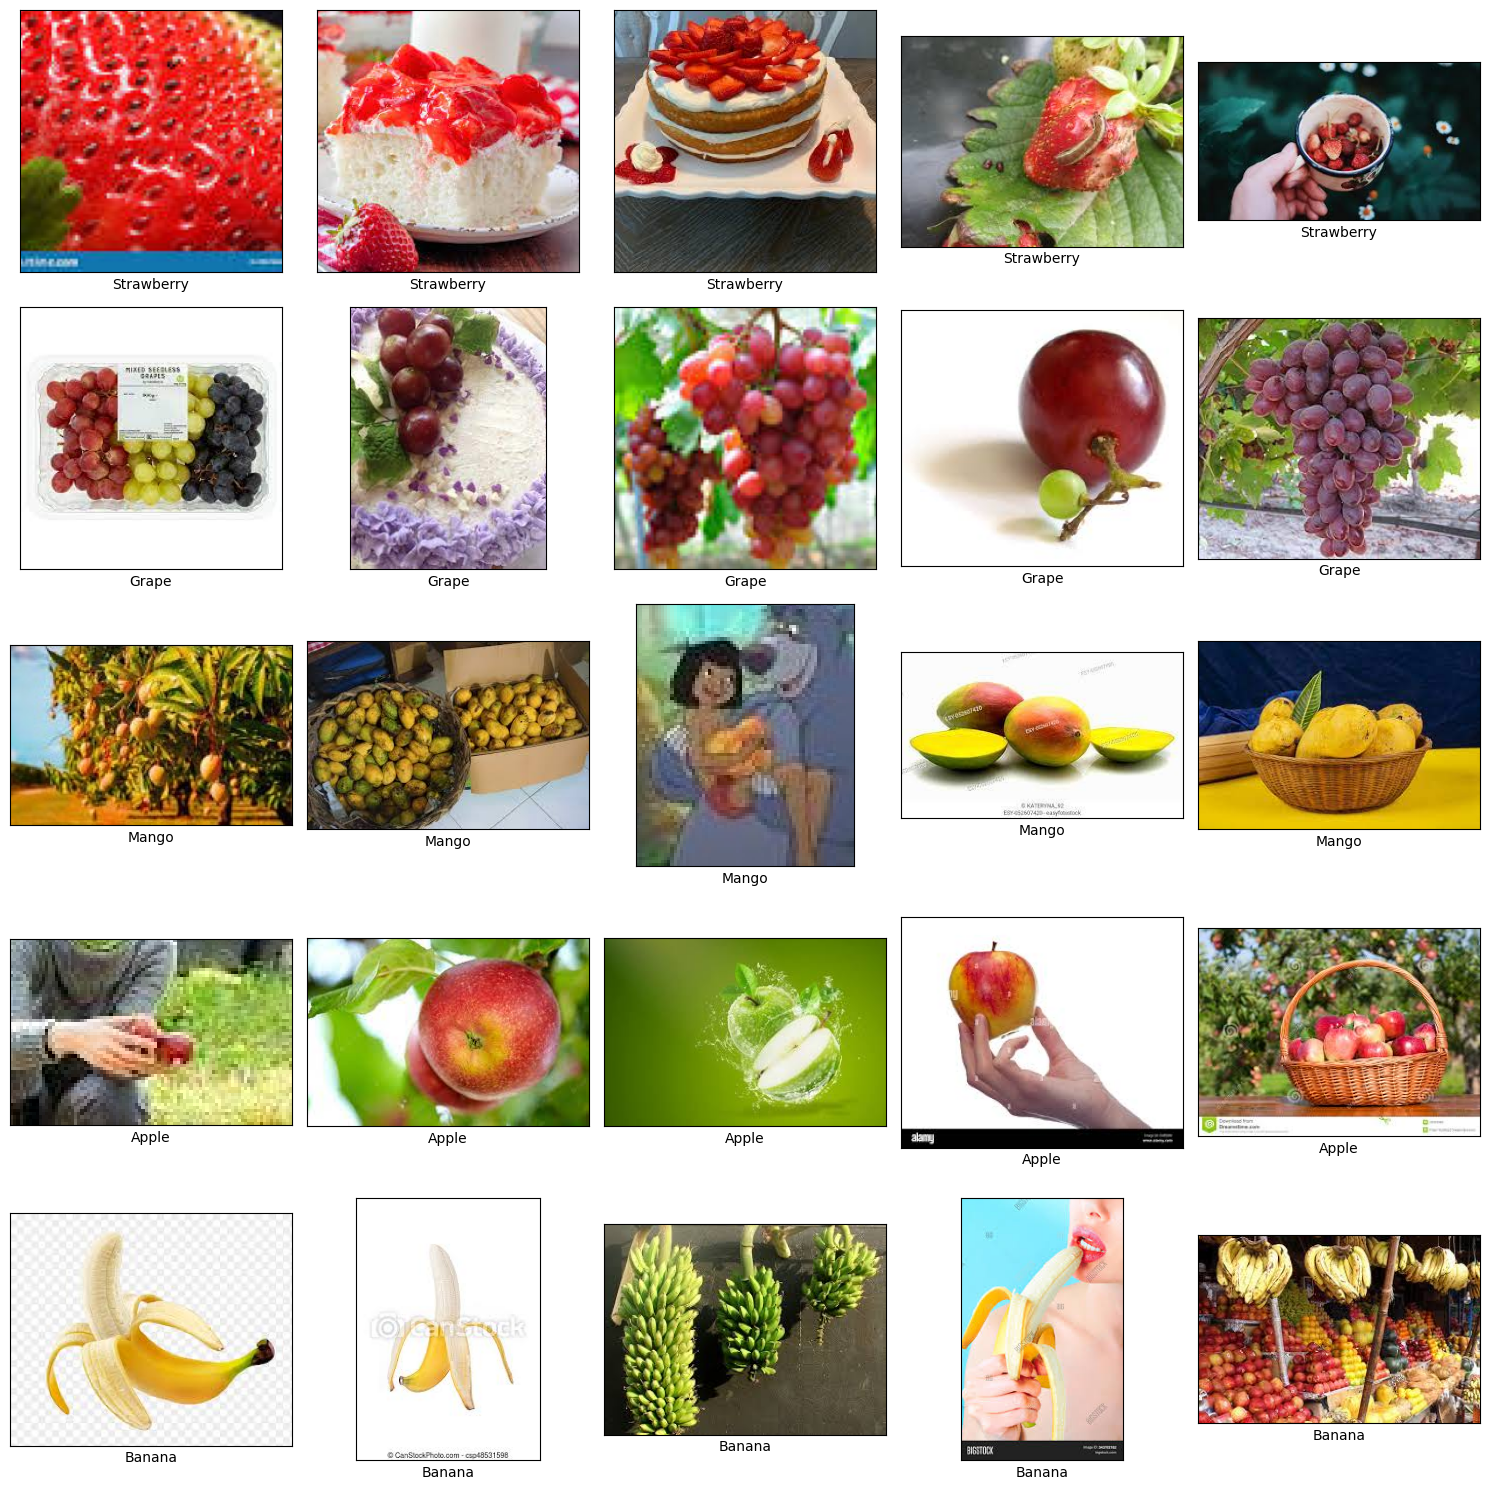

In [11]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
fruit_images = {}

# Tentukan path sumber train
path = "fruits-classification/"
path_sub = os.path.join(path, "dataset_combined")
for i in os.listdir(path_sub):
    fruit_images[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali.
path_sub = "fruits-classification/dataset_combined"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(fruit_images.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(fruit_images[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

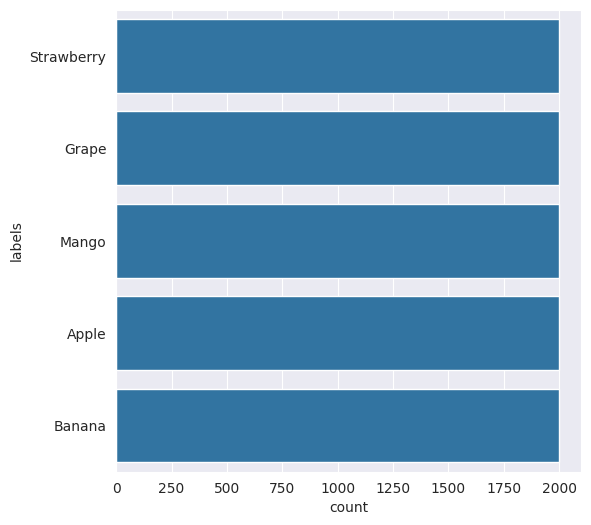

In [12]:
# Define source path
fruit_path = "fruits-classification/dataset_combined"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(fruit_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

#### Split Dataset

In [13]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'fruits-classification/dataset_combined'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Apple,2000
Banana,2000
Grape,2000
Mango,2000
Strawberry,2000


In [14]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=300)

In [15]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})
df_val = pd.DataFrame({'path': X_val, 'labels': y_val, 'set': 'valid'})


In [16]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))
print('valid size', len(df_val))

train size 6400
test size 2000
valid size 1600


In [17]:
# Gabungkan Train, Test, dan Validation
df_all = pd.concat([df_tr, df_te, df_val], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))



set    labels    
test   Apple          383
       Banana         417
       Grape          384
       Mango          405
       Strawberry     411
train  Apple         1291
       Banana        1276
       Grape         1304
       Mango         1279
       Strawberry    1250
valid  Apple          326
       Banana         307
       Grape          312
       Mango          316
       Strawberry     339
dtype: int64 


                                                   path      labels    set
3302  fruits-classification/dataset_combined/Mango/M...       Mango  train
9978  fruits-classification/dataset_combined/Mango/M...       Mango  valid
633   fruits-classification/dataset_combined/Banana/...      Banana  train
1977  fruits-classification/dataset_combined/Apple/A...       Apple  train
6909  fruits-classification/dataset_combined/Strawbe...  Strawberry   test


In [18]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "fruits-classification/dataset_combined/"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [19]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [20]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"
VALID_DIR = "Dataset-Final/valid/"

#train path
train_apple = os.path.join(TRAIN_DIR + '/Apple')
train_banana = os.path.join(TRAIN_DIR + '/Banana')
train_grape = os.path.join(TRAIN_DIR + '/Grape')
train_mango = os.path.join(TRAIN_DIR + '/Mango')
train_strawberry = os.path.join(TRAIN_DIR + '/Strawberry')

#test path
test_apple = os.path.join(TEST_DIR + '/Apple')
test_banana = os.path.join(TEST_DIR + '/Banana')
test_grape = os.path.join(TEST_DIR + '/Grape')
test_mango = os.path.join(TEST_DIR + '/Mango')
test_strawberry = os.path.join(TEST_DIR + '/Strawberry')

#valid path
valid_apple = os.path.join(VALID_DIR + '/Apple')
valid_banana = os.path.join(VALID_DIR + '/Banana')
valid_grape = os.path.join(VALID_DIR + '/Grape')
valid_mango = os.path.join(VALID_DIR + '/Mango')
valid_strawberry = os.path.join(VALID_DIR + '/Strawberry')

#total images in training
print("Total number of apple images in training set: ",len(os.listdir(train_apple)))
print("Total number of banana images in training set: ",len(os.listdir(train_banana)))
print("Total number of grape images in training set: ",len(os.listdir(train_grape)))
print("Total number of mango images in training set: ",len(os.listdir(train_mango)))
print("Total number of strawberry images in training set: ",len(os.listdir(train_strawberry)))

#total images in test
print("Total number of apple images in test set: ",len(os.listdir(test_apple)))
print("Total number of banana images in test set: ",len(os.listdir(test_banana)))
print("Total number of grape images in test set: ",len(os.listdir(test_grape)))
print("Total number of mango images in test set: ",len(os.listdir(test_mango)))
print("Total number of strawberry images in test set: ",len(os.listdir(test_strawberry)))

#total images in valid
print("Total number of apple images in valid set: ",len(os.listdir(valid_apple)))
print("Total number of banana images in valid set: ",len(os.listdir(valid_banana)))
print("Total number of grape images in valid set: ",len(os.listdir(valid_grape)))
print("Total number of mango images in valid set: ",len(os.listdir(valid_mango)))
print("Total number of strawberry images in valid set: ",len(os.listdir(valid_strawberry)))

Total number of apple images in training set:  1291
Total number of banana images in training set:  1276
Total number of grape images in training set:  1304
Total number of mango images in training set:  1279
Total number of strawberry images in training set:  1250
Total number of apple images in test set:  383
Total number of banana images in test set:  417
Total number of grape images in test set:  384
Total number of mango images in test set:  405
Total number of strawberry images in test set:  411
Total number of apple images in valid set:  326
Total number of banana images in valid set:  307
Total number of grape images in valid set:  312
Total number of mango images in valid set:  316
Total number of strawberry images in valid set:  339


In [21]:
for category in ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']:
    path = os.path.join(VALID_DIR, category)
    print(f"{category}: {len(os.listdir(path))} images")


Apple: 326 images
Banana: 307 images
Grape: 312 images
Mango: 316 images
Strawberry: 339 images


In [22]:
# Create an ImageDataGenerator object normalizing the images
datagen = ImageDataGenerator(rescale=1/255.,
                             rotation_range=40,
                             width_shift_range=0.3,
                             height_shift_range=0.3,
                             shear_range=0.3,
                             zoom_range=0.3,
                             horizontal_flip=True,
                             brightness_range=[0.8, 1.2],
                             channel_shift_range=30.0,
                             fill_mode='nearest'
                            )

val_test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(224, 224),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              shuffle=True)

validation_generator = val_test_datagen.flow_from_directory(VALID_DIR,
                                                            batch_size=32,
                                                            target_size=(224, 224),
                                                            color_mode="rgb",
                                                            class_mode='categorical',
                                                            shuffle=False)

test_generator = val_test_datagen.flow_from_directory(TEST_DIR,
                                                      batch_size=1,
                                                      target_size=(224, 224), # Ensure this matches expected input size
                                                      color_mode="rgb",
                                                      class_mode='categorical',
                                                      shuffle=False)

Found 6400 images belonging to 5 classes.
Found 1600 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.


## Modelling

In [23]:
from tensorflow.keras import Sequential, layers, applications, optimizers, callbacks
from sklearn.utils import class_weight

# Load base model
base_model = applications.MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)
base_model.trainable = False

# Buat model sequential
clf_model = Sequential([
    layers.Input(shape=(224, 224, 3)),
    base_model,

    # Tambahkan Conv2D & MaxPooling secara eksplisit
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),

    # Output layer
    layers.Dense(5, activation='softmax')  # ganti 5 sesuai jumlah kelas kamu
])

# Hitung class weights otomatis
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


# Compile
clf_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

# Training
history = clf_model.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator,
    callbacks=[
        callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        callbacks.ModelCheckpoint('FruitClf_ExplicitConv.keras', save_best_only=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
    ],
    class_weight=class_weights
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 128s 514ms/step - accuracy: 0.2212 - loss: 1.6957 - val_accuracy: 0.6044 - val_loss: 1.3748 - learning_rate: 1.0000e-05
Epoch 2/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 93s 464ms/step - accuracy: 0.3778 - loss: 1.4576 - val_accuracy: 0.6787 - val_loss: 1.0229 - learning_rate: 1.0000e-05
Epoch 3/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 95s 473ms/step - accuracy: 0.5215 - loss: 1.1989 - val_accuracy: 0.7575 - val_loss: 0.7540 - learning_rate: 1.0000e-05
Epoch 4/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 94s 471ms/step - accuracy: 0.6059 - loss: 1.0007 - val_accuracy: 0.7812 - val_loss: 0.6254 - learning_rate: 1.0000e-05
Epoch 5/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 93s 463ms/step - accuracy: 0.6825 - loss: 0.8616 - val_accuracy: 0.8050 - val_loss: 0.5672 - learning_rate: 1.0000e-05
Epoch 6/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 93s 464ms/step - accuracy: 0.7027 - loss: 0.7895 - val_accuracy: 0.8125 - val_loss: 0.5373 - learning_rate: 1.0000e-05
Epoch 7/40
200/200 ━━━━━━━━━━━━━━━━━━━━ 91s 4

## Evaluasi dan Visualisasi

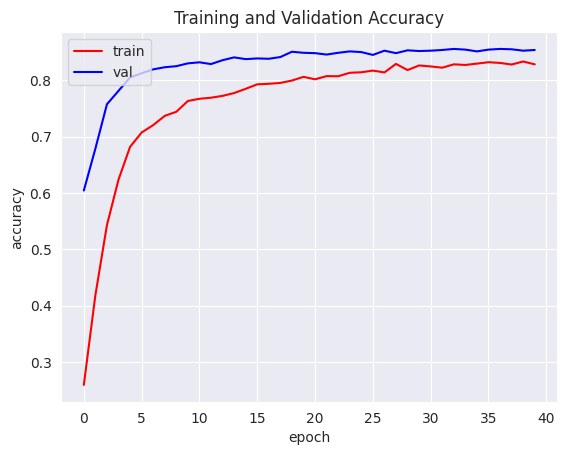

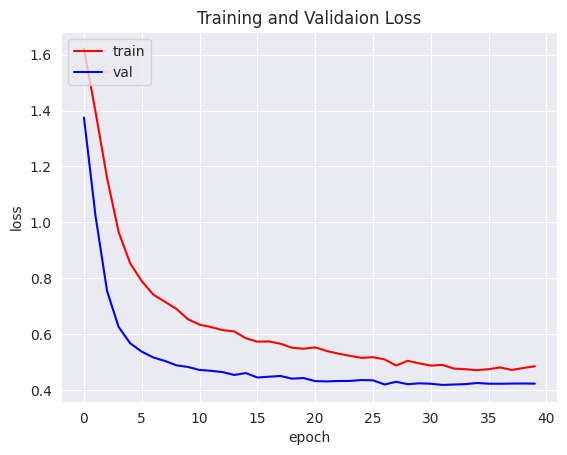

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

## Konversi Model

In [25]:
import tensorflow as tf
import os
import shutil
from google.colab import files
import tensorflowjs as tfjs

# === 1️⃣ Buat Direktori Submission ===
submission_dir = "submission"
os.makedirs(f"{submission_dir}/tfjs_model", exist_ok=True)
os.makedirs(f"{submission_dir}/tflite", exist_ok=True)
os.makedirs(f"{submission_dir}/saved_model", exist_ok=True)

# === 2️⃣ Simpan Model dalam Format SavedModel (tanpa ekstensi) ===
saved_model_path = os.path.join(submission_dir, "saved_model")
tf.saved_model.save(clf_model, saved_model_path)
print("✅ Model disimpan sebagai SavedModel")

# === 3️⃣ Konversi ke TF-Lite ===
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

# Simpan model TF-Lite
tflite_path = f"{submission_dir}/tflite/model.tflite"
with open(tflite_path, "wb") as f:
    f.write(tflite_model)
print("✅ Model dikonversi ke TF-Lite")

# Simpan label kelas untuk TF-Lite
class_labels = ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']
label_path = f"{submission_dir}/tflite/label.txt"
with open(label_path, "w") as f:
    for label in class_labels:
        f.write(label + "\n")
print("✅ Label kelas disimpan dalam label.txt")

# === 4️⃣ Konversi ke TFJS ===
tfjs_path = f"{submission_dir}/tfjs_model"
tfjs.converters.convert_tf_saved_model(saved_model_path, tfjs_path)
print("✅ Model dikonversi ke TFJS")

# === 5️⃣ ZIP Folder Submission ===
shutil.make_archive("submission", 'zip', "submission")
files.download("submission.zip")
print("✅ Folder submission.zip berhasil dibuat dan siap di-download!")


✅ Model disimpan sebagai SavedModel
✅ Model dikonversi ke TF-Lite
✅ Label kelas disimpan dalam label.txt
✅ Model dikonversi ke TFJS


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Folder submission.zip berhasil dibuat dan siap di-download!


## Inference (Optional)